In [3]:
# Check that we have access to gpu

!nvidia-smi

Sat May  6 21:15:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Set up COLAB with KAGGLE api to download the dataset

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
 !pip install -q kaggle

In [7]:
!kaggle datasets download -d sshikamaru/car-object-detection

 95% 107M/112M [00:00<00:00, 186MB/s] 
100% 112M/112M [00:00<00:00, 167MB/s]


In [ ]:
!mkdir car-object-detection
!unzip car-object-detection.zip -d car-object-detection

# NOTEBOOK

In [9]:
# import
import os
import random
import shutil

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import cv2
import tensorflow as tf

import IPython.display

In [10]:
# set up paths
BASE_DIR = os.getcwd()
DATA_DIR = "/content/car-object-detection/data"

# Helper Functions

In [ ]:
# helper function to copy the images
def copy_from_to(src_path: str, dst_path: str, file_ext: str) -> None:
    for file_name in os.listdir(src_path):
        if file_name.endswith(f".{file_ext}"):
            src_file_path = os.path.join(src_path, file_name)
            dst_file_path = os.path.join(dst_path, file_name)
            shutil.copy(src_file_path, dst_file_path)

In [ ]:
# helper function to create labels files
def create_labels(df, dst_dir: str) -> None:
    for _, row in df.iterrows():
        class_name = row['classes']
        x_centre = row['x_centre']
        y_centre = row['y_centre']
        w = row['w']
        h = row['h']
        filename = f"{row['image_id']}.txt"
        if filename in os.listdir(dst_dir):
            with open(f"{dst_dir}/{filename}", "at",) as f:
                f.write(f"0 {x_centre} {y_centre} {w} {h}\n")
        else:
            with open(f"{dst_dir}/{filename}", "wt") as f:
                f.write(f"0 {x_centre} {y_centre} {w} {h}\n")

In [ ]:
# helper function to show results
def show_results(src_dir: str) -> None:
    for f in os.listdir(src_dir):
      if f.endswith(".png") or f.endswith(".jpg"):
        # Open the image
        image = Image.open(f"{src_dir}/{f}")
    
        # Set the width to 800 and calculate the height
        width = 800
        height = 800
    
        # Resize the image
        image = image.resize((width, height), Image.ANTIALIAS)
    
        # Display the image
        IPython.display.display(image)

## Set up labels and annotation for YOLOv8

In [11]:
img_h, img_w, num_channels = (380, 676, 3)

df = pd.read_csv(f'{DATA_DIR}/train_solution_bounding_boxes (1).csv')
df.head()

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422


In [12]:
df['image'].value_counts()

vid_4_26460.jpg    7
vid_4_6240.jpg     6
vid_4_6280.jpg     5
vid_4_26380.jpg    5
vid_4_26420.jpg    5
                  ..
vid_4_18840.jpg    1
vid_4_18820.jpg    1
vid_4_18340.jpg    1
vid_4_18360.jpg    1
vid_4_9980.jpg     1
Name: image, Length: 355, dtype: int64

In [13]:
df.rename(columns={'image': 'image_id'}, inplace=True)
df['image_id'] = df['image_id'].apply(lambda x: x.split('.')[0])

df['classes'] = 0
df['x_centre'] = (df['xmin'] + df['xmax'])/2
df['y_centre'] = (df['ymin'] + df['ymax'])/2
df['w'] = df['xmax'] - df['xmin']
df['h'] = df['ymax'] - df['ymin']
df['x_centre'] = df['x_centre']/img_w
df['w'] = df['w']/img_w
df['y_centre'] = df['y_centre']/img_h
df['h'] = df['h']/img_h
df.head()

,image_id,xmin,ymin,xmax,ymax,classes,x_centre,y_centre,w,h
0,vid_4_1000,281.259045,187.035071,327.727931,223.225547,0,0.450434,0.539817,0.068741,0.095238
1,vid_4_10000,15.163531,187.035071,120.329957,236.430180,0,0.100217,0.557191,0.155572,0.129987
2,vid_4_10040,239.192475,176.764801,361.968162,236.430180,0,0.444645,0.543678,0.181621,0.157014
3,vid_4_10020,496.483358,172.363256,630.020260,231.539575,0,0.833213,0.531451,0.197540,0.155727
4,vid_4_10060,16.630970,186.546010,132.558611,238.386422,0,0.110347,0.559122,0.171491,0.136422


In [14]:
os.makedirs(f"{BASE_DIR}/without-augmentation/train/images")
os.makedirs(f"{BASE_DIR}/without-augmentation/train/labels")

os.makedirs(f"{BASE_DIR}/without-augmentation/test/images")

os.makedirs(f"{BASE_DIR}/with-augmentation/train/images")
os.makedirs(f"{BASE_DIR}/with-augmentation/train/labels")

os.makedirs(f"{BASE_DIR}/with-augmentation/test/images")

In [17]:
!tree -d

.
├── car-object-detection
│   └── data
│       ├── testing_images
│       └── training_images
├── sample_data
├── with-augmentation
│   ├── test
│   │   └── images
│   └── train
│       ├── images
│       └── labels
└── without-augmentation
    ├── test
    │   └── images
    └── train
        ├── images
        └── labels

17 directories


In [19]:
# copy images
copy_from_to(f"{DATA_DIR}/training_images", f"{BASE_DIR}/without-augmentation/train/images/", "jpg")

copy_from_to(f"{DATA_DIR}/testing_images", f"{BASE_DIR}/without-augmentation/test/images/", "jpg")

copy_from_to(f"{DATA_DIR}/testing_images", f"{BASE_DIR}/with-augmentation/test/images/", "jpg")

copy_from_to(f"{DATA_DIR}/training_images", f"{BASE_DIR}/with-augmentation/train/images/", "jpg")

In [21]:
create_labels(df, f"{BASE_DIR}/without-augmentation/train/labels")

In [22]:
copy_from_to(f"{BASE_DIR}/without-augmentation/train/labels", f"{BASE_DIR}/with-augmentation/train/labels", "txt")

## Download the pre trainied model YOLOv8

In [23]:
# install ultralytics package using cli

!pip install ultralytics

IPython.display.clear_output()

import ultralytics

ultralytics.checks()

Ultralytics YOLOv8.0.93 🚀 Python-3.10.11 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 23.9/78.2 GB disk)


In [24]:
from ultralytics import YOLO

## Train the YOLOv8 model on dataset without augmentaion

In [25]:
# craete yaml config file
text = f"""
# Train/val/test sets
path: {BASE_DIR}/without-augmentation
train: train/images
val: train/images
test:  test/images

# Classes
names:
  0: car
"""

with open(f"{BASE_DIR}/without_augmentation.yaml", "wt") as f:
    f.write(text)

In [26]:
# Load a model
model_1 = YOLO('yolov8n.yaml').load('yolov8n.pt')  # build from YAML and transfer weights

# Train the model
model_1.train(data="without_augmentation.yaml", imgsz=(img_w, img_h), device=0, workers=12, save=True, plots=True)


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.Conv                  [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.Conv                  [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.C2f                   [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.Conv                  [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.C2f                   [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.Conv                  [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.C2f                   [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.Conv                  [128

In [ ]:
show_results(f"{BASE_DIR}/runs/detect/train")

In [31]:
# Validate the model
model_1 = YOLO(f"{BASE_DIR}/runs/detect/train/weights/best.pt")
model_1.val()

Ultralytics YOLOv8.0.93 🚀 Python-3.10.11 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning /content/without-augmentation/train/labels.cache... 355 images, 646 backgrounds, 0 corrupt: 100%|██████████| 1001/1001 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:10<00:00,  5.86it/s]
                   all       1001        559      0.994      0.995      0.995      0.842
Speed: 0.7ms preprocess, 3.6ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/val


ultralytics.yolo.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.yolo.utils.metrics.Metric object
confusion_matrix: <ultralytics.yolo.utils.metrics.ConfusionMatrix object at 0x7fe4d236e440>
fitness: 0.8573245332642969
keys: ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']
maps: array([    0.84204])
names: {0: 'car'}
plot: True
results_dict: {'metrics/precision(B)': 0.9944720009256988, 'metrics/recall(B)': 0.9946332737030411, 'metrics/mAP50(B)': 0.9948918918918919, 'metrics/mAP50-95(B)': 0.842039271194564, 'fitness': 0.8573245332642969}
save_dir: PosixPath('runs/detect/val')
speed: {'preprocess': 0.671755422007192, 'inference': 3.5702732059505435, 'loss': 0.001381208132077883, 'postprocess': 1.0617829702950858}

In [ ]:
show_results(f"{BASE_DIR}/runs/detect/val")

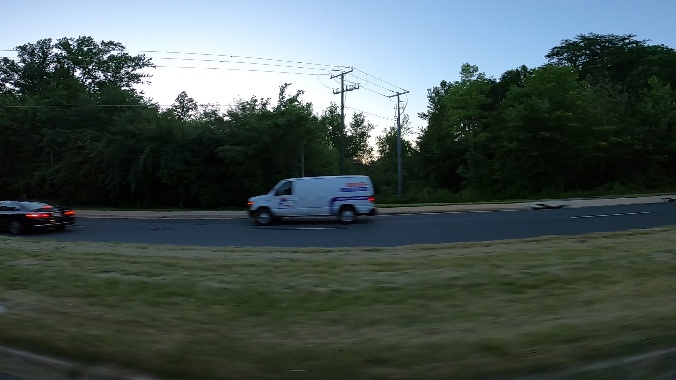

In [40]:
# Inference with Custom Model
index = list(set(os.listdir(f'{BASE_DIR}/without-augmentation/test/images/')))
img_name = random.choice(index)
IPython.display.Image(filename=f'{BASE_DIR}/without-augmentation/test/images/{img_name}',width=800)

In [41]:
model_1.predict(f'{BASE_DIR}/without-augmentation/test/images/{img_name}', save=True)


image 1/1 /content/without-augmentation/test/images/vid_5_26780.jpg: 416x704 2 cars, 66.1ms
Speed: 3.1ms preprocess, 66.1ms inference, 2.0ms postprocess per image at shape (1, 3, 704, 704)
Results saved to runs/detect/predict


[ultralytics.yolo.engine.results.Results object with attributes:
 
 boxes: ultralytics.yolo.engine.results.Boxes object
 keypoints: None
 keys: ['boxes']
 masks: None
 names: {0: 'car'}
 orig_img: array([[[234, 199, 173],
         [235, 200, 174],
         [235, 200, 174],
         ...,
         [208, 160, 118],
         [208, 160, 118],
         [208, 160, 118]],
 
        [[236, 201, 175],
         [236, 201, 175],
         [236, 201, 175],
         ...,
         [209, 161, 119],
         [209, 161, 119],
         [209, 161, 119]],
 
        [[237, 202, 176],
         [236, 201, 175],
         [236, 201, 175],
         ...,
         [208, 160, 118],
         [208, 160, 118],
         [208, 160, 118]],
 
        ...,
 
        [[ 42,  35,  26],
         [ 42,  35,  26],
         [ 42,  35,  26],
         ...,
         [ 42,  37,  28],
         [ 44,  39,  30],
         [ 45,  40,  31]],
 
        [[ 44,  35,  26],
         [ 44,  35,  26],
         [ 44,  35,  26],
         ...,
     

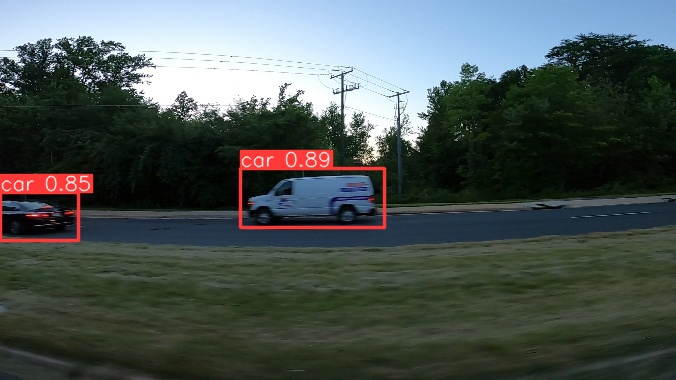

In [42]:
IPython.display.Image(filename=f'{BASE_DIR}/runs/detect/predict/{img_name}',width=800)

## Train the YOLOv8 model on dataset with augmentaion

In [43]:
# helper function to return the image_filenames, annotation_filenames
def return_files_name(image_path: str, annotation_path: str):
    image_filenames, annotation_filenames = [], []
    for name in os.listdir(annotation_path):
        image_filenames.append(f"{name.split('.')[0]}.jpg")
        annotation_filenames.append(name)
    return image_filenames, annotation_filenames

In [44]:
image_filenames, annotation_filenames = return_files_name(f"{BASE_DIR}/without-augmentation/train/images", f"{BASE_DIR}/without-augmentation/train/labels")

In [45]:
# Load the dataset
dataset = tf.data.Dataset.from_tensor_slices((image_filenames, annotation_filenames))

In [46]:
dataset = dataset.shuffle(len(image_filenames)).batch(2)

In [47]:
# Mixup augmentation function
def mixup(images, annotations, alpha: float):
    img_1_name = images[0].decode('utf-8')
    img_2_name = images[1].decode('utf-8')
    annotation_1_name = annotations[0].decode('utf-8')
    annotation_2_name = annotations[1].decode('utf-8')

    img_1 = cv2.imread(f"{BASE_DIR}/without-augmentation/train/images/{img_1_name}", cv2.IMREAD_COLOR)
    img_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB)
    
    img_2 = cv2.imread(f"{BASE_DIR}/without-augmentation/train/images/{img_2_name}", cv2.IMREAD_COLOR)
    img_2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB)
    
    # Generate a random mixing lamda
    lamda = np.random.beta(alpha, alpha)

    # Mix the images
    mixed_image = (lamda * img_1) + ((1 - lamda) * img_2 )
    mixed_image = mixed_image.astype(np.uint8)
    
    # Mix the annotations
    text, mixed_annotation = [], []
    for i in [annotation_1_name, annotation_2_name]:
        with open(f"{BASE_DIR}/without-augmentation/train/labels/{i}", 'rt') as f:
            text.append(f.readlines())
    for i in range(2):
        for line in text[i]:
            mixed_annotation.append(line)
    
    return mixed_image, mixed_annotation

In [48]:
# apply Mixup augmentation
mixed_image, mixed_annotation = 1, 2
for images, annotations in dataset.as_numpy_iterator():
    
    if len(images) < 2:
        continue
    mixed_image, mixed_annotation = mixup(images, annotations, 0.5)
    
    img_1_name = images[0].decode('utf-8').split('.')[0]
    img_2_name = images[1].decode('utf-8').split('.')[0]
    annotation_1_name = annotations[0].decode('utf-8').split('.')[0]
    annotation_2_name = annotations[1].decode('utf-8').split('.')[0]
    
    mixed_image = cv2.cvtColor(mixed_image, cv2.COLOR_RGB2BGR)
    cv2.imwrite(f"{BASE_DIR}/with-augmentation/train/images/{img_1_name}.{img_2_name}.jpg", mixed_image)
    
    with open(f"{BASE_DIR}/with-augmentation/train/labels/{annotation_1_name}.{annotation_2_name}.txt", 'wt') as f:
        for line in mixed_annotation:
            f.write(line)

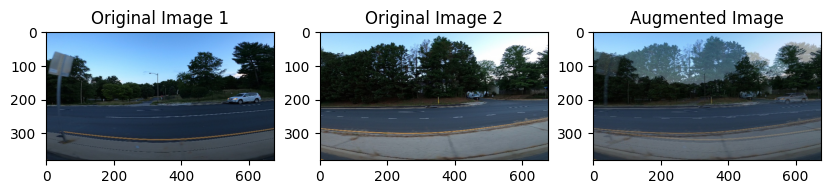

In [50]:
# display Mixedup image and their base two images
list_of_images_names = os.listdir(f"{BASE_DIR}/with-augmentation/train/images/")

import re
pattern = re.compile(r"vid_[0-9]+_[0-9]+.vid_[0-9]+_[0-9]+.jpg")
augmented_images_names = []
for i in list_of_images_names:
    if pattern.match(i):
        augmented_images_names.append(i)

c = random.choices(augmented_images_names)
img_1 = Image.open(f"{BASE_DIR}/with-augmentation/train/images/{c[0].split('.')[0]}.jpg")
img_2 = Image.open(f"{BASE_DIR}/with-augmentation/train/images/{c[0].split('.')[1]}.jpg")
img_mixed = Image.open(f"{BASE_DIR}/with-augmentation/train/images/{c[0]}")
# Plot the original and augmented image
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 6))
ax[0].imshow(img_1)
ax[0].set_title("Original Image 1")
ax[1].imshow(img_2)
ax[1].set_title("Original Image 2")
ax[2].imshow(img_mixed)
ax[2].set_title("Augmented Image")
plt.show()

### Train the model on augmentated dataset

In [51]:
# craete yaml config file
text = f"""
# Train/val/test sets
path: {BASE_DIR}/with-augmentation
train: train/images
val: train/images
test:  test/images

# Classes
names:
  0: car
"""

with open(f"{BASE_DIR}/with_augmentation.yaml", "wt") as f:
    f.write(text)

In [52]:
# Load a model
model_2 = YOLO('yolov8n.yaml').load('yolov8n.pt')  # build from YAML and transfer weights

# Train the model
model_2.train(data="with_augmentation.yaml", imgsz=(img_w, img_h), device=0, workers=12, save=True, plots=True)


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.Conv                  [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.Conv                  [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.C2f                   [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.Conv                  [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.C2f                   [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.Conv                  [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.C2f                   [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.Conv                  [128

In [ ]:
show_results(f"{BASE_DIR}/runs/detect/train2")

In [54]:
# Validate the model
model_2 = YOLO(f"{BASE_DIR}/runs/detect/train2/weights/best.pt")
model_2.val()

Ultralytics YOLOv8.0.93 🚀 Python-3.10.11 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning /content/with-augmentation/train/labels.cache... 532 images, 646 backgrounds, 0 corrupt: 100%|██████████| 1178/1178 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:13<00:00,  5.58it/s]
                   all       1178       1117      0.965      0.926      0.973      0.843
Speed: 0.5ms preprocess, 3.0ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/val2


ultralytics.yolo.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.yolo.utils.metrics.Metric object
confusion_matrix: <ultralytics.yolo.utils.metrics.ConfusionMatrix object at 0x7fe51a52e800>
fitness: 0.8557281834462777
keys: ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']
maps: array([    0.84268])
names: {0: 'car'}
plot: True
results_dict: {'metrics/precision(B)': 0.9654530910452822, 'metrics/recall(B)': 0.9257005798877566, 'metrics/mAP50(B)': 0.9731428220204807, 'metrics/mAP50-95(B)': 0.8426821124935884, 'fitness': 0.8557281834462777}
save_dir: PosixPath('runs/detect/val2')
speed: {'preprocess': 0.54071208617076, 'inference': 2.960636376929809, 'loss': 0.0011920928955078125, 'postprocess': 1.5502067089890381}

In [ ]:
show_results(f"{BASE_DIR}/runs/detect/val2")

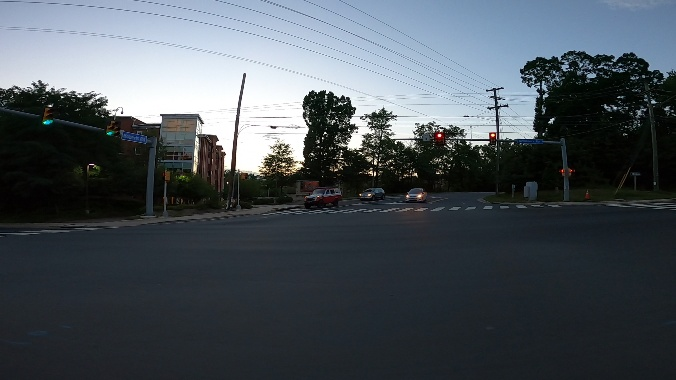

In [67]:
# Inference with Custom Model
index = list(set(os.listdir(f'{BASE_DIR}/with-augmentation/test/images/')))
img_name = random.choice(index)
IPython.display.Image(filename=f'{BASE_DIR}/with-augmentation/test/images/{img_name}',width=800)

In [68]:
model_2.predict(f'{BASE_DIR}/with-augmentation/test/images/{img_name}', save=True)


image 1/1 /content/with-augmentation/test/images/vid_5_27400.jpg: 416x704 3 cars, 11.7ms
Speed: 3.1ms preprocess, 11.7ms inference, 3.5ms postprocess per image at shape (1, 3, 704, 704)
Results saved to runs/detect/predict2


[ultralytics.yolo.engine.results.Results object with attributes:
 
 boxes: ultralytics.yolo.engine.results.Boxes object
 keypoints: None
 keys: ['boxes']
 masks: None
 names: {0: 'car'}
 orig_img: array([[[189, 163, 147],
         [188, 162, 146],
         [187, 161, 145],
         ...,
         [150, 121, 100],
         [149, 120,  99],
         [149, 120,  99]],
 
        [[149, 123, 107],
         [146, 120, 104],
         [142, 116, 100],
         ...,
         [149, 120,  99],
         [149, 120,  99],
         [150, 121, 100]],
 
        [[183, 157, 141],
         [184, 158, 142],
         [184, 158, 142],
         ...,
         [151, 122, 101],
         [151, 122, 101],
         [151, 122, 101]],
 
        ...,
 
        [[ 33,  28,  27],
         [ 33,  28,  27],
         [ 33,  28,  25],
         ...,
         [ 31,  28,  24],
         [ 30,  27,  23],
         [ 29,  26,  22]],
 
        [[ 33,  28,  27],
         [ 33,  28,  27],
         [ 32,  27,  26],
         ...,
     

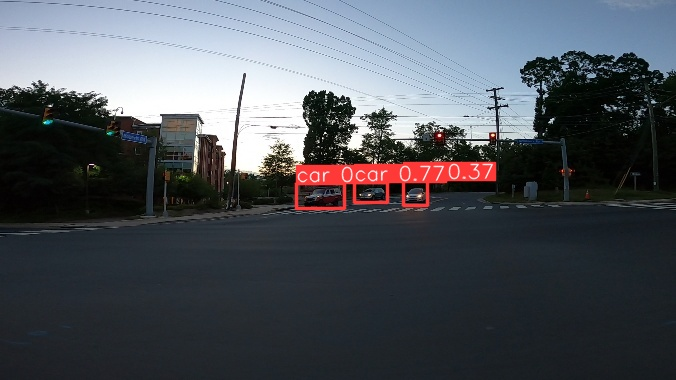

In [69]:
IPython.display.Image(filename=f'{BASE_DIR}/runs/detect/predict2/{img_name}',width=800)

---

In [70]:
# compress the results for saving
import zipfile
with zipfile.ZipFile("runs.zip", 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(f"{BASE_DIR}/runs/"):
        for fil in files:
            # Construct the full file path
            file_path = os.path.join(root, fil)
            # Add the file to the zipfile
            zipf.write(file_path, os.path.relpath(file_path, f"{BASE_DIR}/runs/"))